In [55]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [56]:
#!pip install catboost

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [58]:
myfolder = "./"

# **Columns' names**

In [59]:
#Columns' names
'''
1)  unit number
2)	time, in cycles
3)	operational setting 1
4)	operational setting 2
5)	operational setting 3
6)	sensor measurement  1
7)	sensor measurement  2
...
26)	sensor measurement  21
'''
unitNames = ['UnitNumber']
timeCycles = ["TimeInCycles"]
operSets = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
sensorMes = ["SensorMes"+str(j) for j in range(1, 22)] # de 1 à 21
columnsNames = unitNames + timeCycles + operSets +sensorMes

# **Datasets loading**

In [60]:
def data_loading(x):
  train_path = myfolder + "train_"+ x +".txt"
  test_path = myfolder + "test_"+ x +".txt"
  rul_path = myfolder + "RUL_"+ x +".txt"
  train = pd.read_csv(train_path, delim_whitespace=True, names=columnsNames)
  test = pd.read_csv(test_path, delim_whitespace=True, names=columnsNames)
  rul = pd.read_csv(rul_path, delim_whitespace=True, names=["RUL_FD"])
  return train, test, rul

train_fd001, test_fd001, rul_fd001 = data_loading("FD001")
train_fd002, test_fd002, rul_fd002 = data_loading("FD002")
train_fd003, test_fd003, rul_fd003 = data_loading("FD003")
train_fd004, test_fd004, rul_fd004 = data_loading("FD004")

In [61]:
# Forcer l'affichage de toutes les colonnes
pd.set_option('display.max_columns', None)

train_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213


# **RUL column generation for train and test set**

In [62]:
def rul_train_generation(x):
  rul = pd.DataFrame(x.groupby('UnitNumber')['TimeInCycles'].max()).reset_index()
  rul.columns = ['UnitNumber', 'max']
  x = x.merge(rul, on=['UnitNumber'], how='left')
  x['RUL'] = x['max'] - x['TimeInCycles']
  x.drop('max', axis=1, inplace=True)
  return x

train_fd001 = rul_train_generation(train_fd001)
train_fd002 = rul_train_generation(train_fd002)
train_fd003 = rul_train_generation(train_fd003)
train_fd004 = rul_train_generation(train_fd004)

In [63]:
train_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213,318


In [64]:
def rul_test_generation(x, rul):

  rul["UnitNumber"] = rul.index + 1 # +1 pour que UnitNumber demarre de 1 au lieu de 0, car il s'agit du numero des moteur

  x = x.merge(rul, on=['UnitNumber'], how='left')

  max_cycle = pd.DataFrame(x.groupby('UnitNumber')['TimeInCycles'].max()).reset_index()
  max_cycle.columns = ['UnitNumber', 'max']
  x = x.merge(max_cycle, on=['UnitNumber'], how='left')
  x['RUL'] = x['RUL_FD'] + x['max'] - x['TimeInCycles']
  x.drop(['max', 'RUL_FD'], axis=1, inplace=True)

  return x

test_fd001 = rul_test_generation(test_fd001, rul_fd001)
test_fd002 = rul_test_generation(test_fd002, rul_fd002)
test_fd003 = rul_test_generation(test_fd003, rul_fd003)
test_fd004 = rul_test_generation(test_fd004, rul_fd004)

In [65]:
test_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21,RUL
0,1,1,20.0072,0.700,100.0,491.19,606.67,1481.04,1227.81,9.35,13.60,332.52,2323.67,8704.98,1.07,43.83,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.620,60.0,462.54,536.22,1256.17,1031.48,7.05,9.00,174.46,1915.21,7999.94,0.93,36.11,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.842,100.0,445.00,549.23,1340.13,1105.88,3.91,5.69,137.34,2211.93,8305.38,1.01,41.52,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249


# **Bivariate Correlation Analysis**

In [66]:
def correl(df):
    plt.figure(figsize=(10, 8))
    cmap = sns.diverging_palette(500, 10, as_cmap=True)
    sns.heatmap(train_fd001.corr(), cmap = cmap, center=0, annot=False, square=True)


def correlation_analyz(df, seuil):
  # Calculer la corrélation entre les variables avec différentes méthodes
  corr_pearson = df.corr(method='pearson')
  corr_spearman = df.corr(method='spearman')
  corr_kendall = df.corr(method='kendall')

  # Colonnes avec corrélation plus faible que le seuil pour chaque méthode
  colonnes_faible_corr_pearson = corr_pearson.loc[corr_pearson['RUL'].abs() < seuil].index.tolist()
  colonnes_faible_corr_spearman = corr_spearman.loc[corr_spearman['RUL'].abs() < seuil].index.tolist()
  colonnes_faible_corr_kendall = corr_kendall.loc[corr_kendall['RUL'].abs() < seuil].index.tolist()

  # Afficher les colonnes avec corrélation plus faible que le seuil pour chaque méthode
  print("Colonnes avec corrélation plus faible que", seuil, "pour la corrélation de Pearson:")
  print(colonnes_faible_corr_pearson)
  print("\nColonnes avec corrélation plus faible que", seuil, "pour la corrélation de Spearman:")
  print(colonnes_faible_corr_spearman)
  print("\nColonnes avec corrélation plus faible que", seuil, "pour la corrélation de Kendall:")
  print(colonnes_faible_corr_kendall)

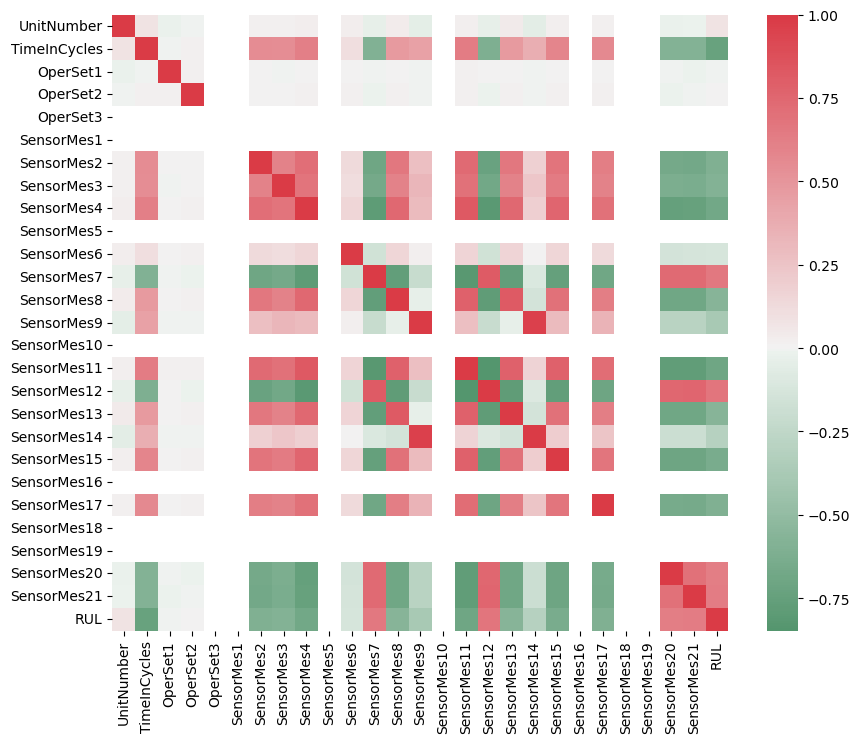

In [67]:
correl(train_fd001)

In [68]:
correlation_analyz(train_fd001, 0.6)

Colonnes avec corrélation plus faible que 0.6 pour la corrélation de Pearson:
['UnitNumber', 'OperSet1', 'OperSet2', 'SensorMes3', 'SensorMes6', 'SensorMes8', 'SensorMes9', 'SensorMes13', 'SensorMes14']

Colonnes avec corrélation plus faible que 0.6 pour la corrélation de Spearman:
['UnitNumber', 'OperSet1', 'OperSet2', 'SensorMes6', 'SensorMes8', 'SensorMes9', 'SensorMes13', 'SensorMes14']

Colonnes avec corrélation plus faible que 0.6 pour la corrélation de Kendall:
['UnitNumber', 'TimeInCycles', 'OperSet1', 'OperSet2', 'SensorMes2', 'SensorMes3', 'SensorMes4', 'SensorMes6', 'SensorMes7', 'SensorMes8', 'SensorMes9', 'SensorMes11', 'SensorMes12', 'SensorMes13', 'SensorMes14', 'SensorMes15', 'SensorMes17', 'SensorMes20', 'SensorMes21']


In [69]:
# Les colonnes à supprimer
operSets_to_drop = ["OperSet"+str(i) for i in [1, 2]] # 1 et 2
sensorMes_to_drop = ["SensorMes"+str(j) for j in [3, 6, 8, 9, 13, 14]]
cols_to_drop = operSets_to_drop + sensorMes_to_drop

# Suppression dans train et test
drop_cols=True
if(drop_cols == True):
  train_fd001 = train_fd001.drop(cols_to_drop, axis=1)
  test_fd001 = test_fd001.drop(cols_to_drop, axis=1)

In [70]:
train_fd001.columns, len(train_fd001.columns)

(Index(['UnitNumber', 'TimeInCycles', 'OperSet3', 'SensorMes1', 'SensorMes2',
        'SensorMes4', 'SensorMes5', 'SensorMes7', 'SensorMes10', 'SensorMes11',
        'SensorMes12', 'SensorMes15', 'SensorMes16', 'SensorMes17',
        'SensorMes18', 'SensorMes19', 'SensorMes20', 'SensorMes21', 'RUL'],
       dtype='object'),
 19)

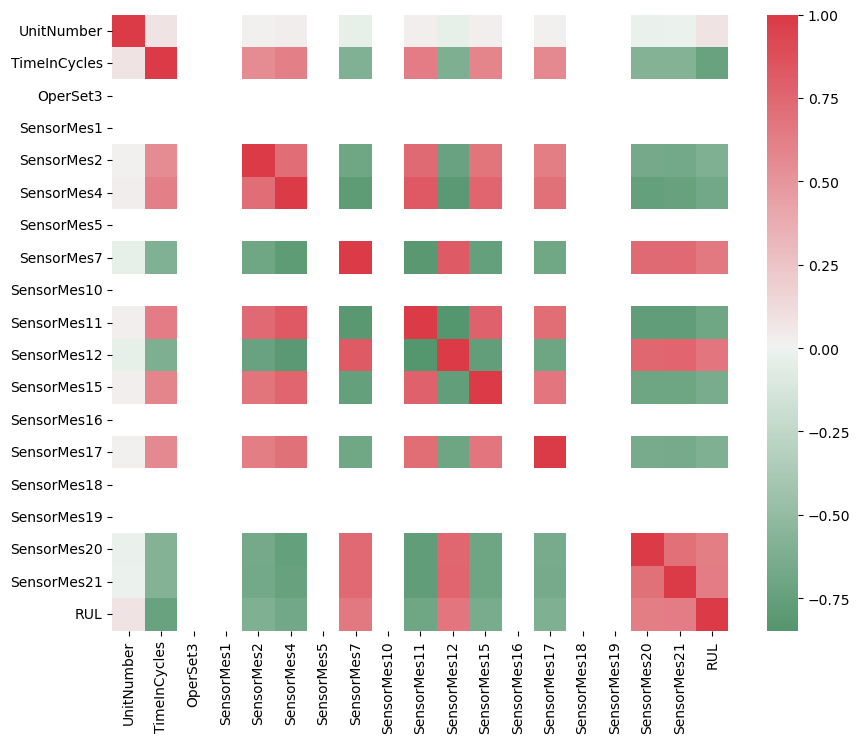

In [71]:
correl(train_fd002)

In [72]:
correlation_analyz(train_fd002, 0.03)

Colonnes avec corrélation plus faible que 0.03 pour la corrélation de Pearson:
['UnitNumber', 'OperSet1', 'OperSet2', 'OperSet3', 'SensorMes1', 'SensorMes2', 'SensorMes3', 'SensorMes5', 'SensorMes6', 'SensorMes7', 'SensorMes8', 'SensorMes9', 'SensorMes10', 'SensorMes12', 'SensorMes13', 'SensorMes17', 'SensorMes18', 'SensorMes19', 'SensorMes20', 'SensorMes21']

Colonnes avec corrélation plus faible que 0.03 pour la corrélation de Spearman:
['UnitNumber', 'OperSet1', 'OperSet2', 'OperSet3', 'SensorMes1', 'SensorMes5', 'SensorMes10', 'SensorMes18', 'SensorMes19']

Colonnes avec corrélation plus faible que 0.03 pour la corrélation de Kendall:
['UnitNumber', 'OperSet1', 'OperSet2', 'OperSet3', 'SensorMes1', 'SensorMes5', 'SensorMes10', 'SensorMes18', 'SensorMes19']


In [73]:
# Les colonnes à supprimer
operSets_to_drop = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
sensorMes_to_drop = ["SensorMes"+str(j) for j in [1, 5, 10, 18, 19]]
cols_to_drop = operSets_to_drop + sensorMes_to_drop

# Suppression dans train et test
drop_cols=True
if(drop_cols == True):
  train_fd002 = train_fd002.drop(cols_to_drop, axis=1)
  test_fd002 = test_fd002.drop(cols_to_drop, axis=1)

In [74]:
train_fd002.columns, len(train_fd002.columns)

(Index(['UnitNumber', 'TimeInCycles', 'SensorMes2', 'SensorMes3', 'SensorMes4',
        'SensorMes6', 'SensorMes7', 'SensorMes8', 'SensorMes9', 'SensorMes11',
        'SensorMes12', 'SensorMes13', 'SensorMes14', 'SensorMes15',
        'SensorMes16', 'SensorMes17', 'SensorMes20', 'SensorMes21', 'RUL'],
       dtype='object'),
 19)

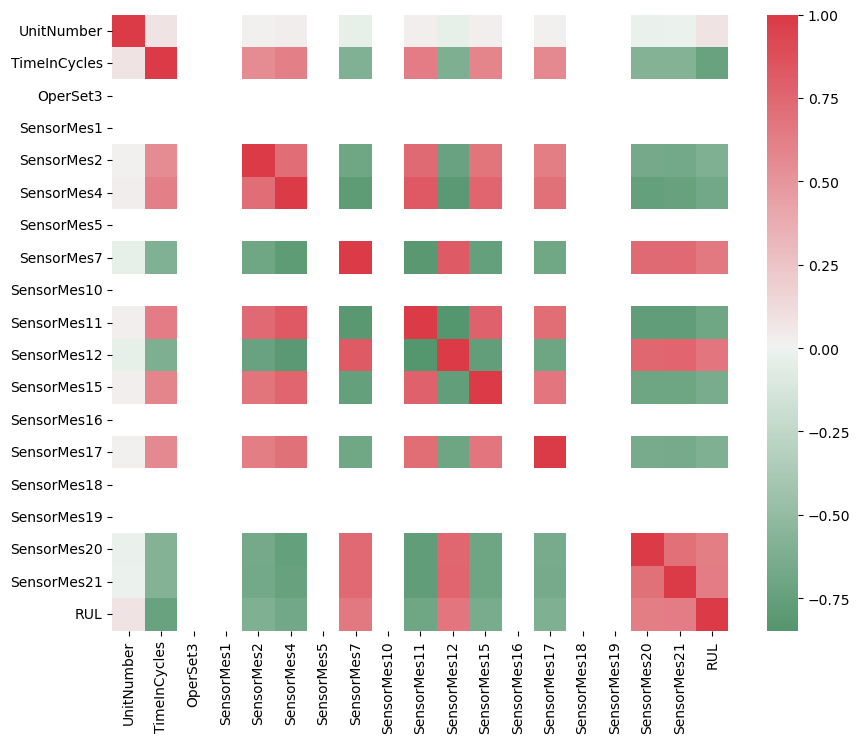

In [75]:
correl(train_fd003)

In [76]:
correlation_analyz(train_fd003, 0.4)

Colonnes avec corrélation plus faible que 0.4 pour la corrélation de Pearson:
['UnitNumber', 'OperSet1', 'OperSet2', 'SensorMes6', 'SensorMes7', 'SensorMes10', 'SensorMes12', 'SensorMes15', 'SensorMes20', 'SensorMes21']

Colonnes avec corrélation plus faible que 0.4 pour la corrélation de Spearman:
['UnitNumber', 'OperSet1', 'OperSet2', 'SensorMes6', 'SensorMes7', 'SensorMes12', 'SensorMes15', 'SensorMes20', 'SensorMes21']

Colonnes avec corrélation plus faible que 0.4 pour la corrélation de Kendall:
['UnitNumber', 'OperSet1', 'OperSet2', 'SensorMes6', 'SensorMes7', 'SensorMes10', 'SensorMes12', 'SensorMes14', 'SensorMes15', 'SensorMes20', 'SensorMes21']


In [77]:
# Les colonnes à supprimer
operSets_to_drop = ["OperSet"+str(i) for i in [1, 2]] # 1 et 2
sensorMes_to_drop = ["SensorMes"+str(j) for j in [6, 7, 10, 12, 15, 20, 21]]
cols_to_drop = operSets_to_drop + sensorMes_to_drop

# Suppression dans train et test
drop_cols=True
if(drop_cols == True):
  train_fd003 = train_fd003.drop(cols_to_drop, axis=1)
  test_fd003 = test_fd003.drop(cols_to_drop, axis=1)

In [78]:
train_fd003.columns, len(train_fd003.columns)

(Index(['UnitNumber', 'TimeInCycles', 'OperSet3', 'SensorMes1', 'SensorMes2',
        'SensorMes3', 'SensorMes4', 'SensorMes5', 'SensorMes8', 'SensorMes9',
        'SensorMes11', 'SensorMes13', 'SensorMes14', 'SensorMes16',
        'SensorMes17', 'SensorMes18', 'SensorMes19', 'RUL'],
       dtype='object'),
 18)

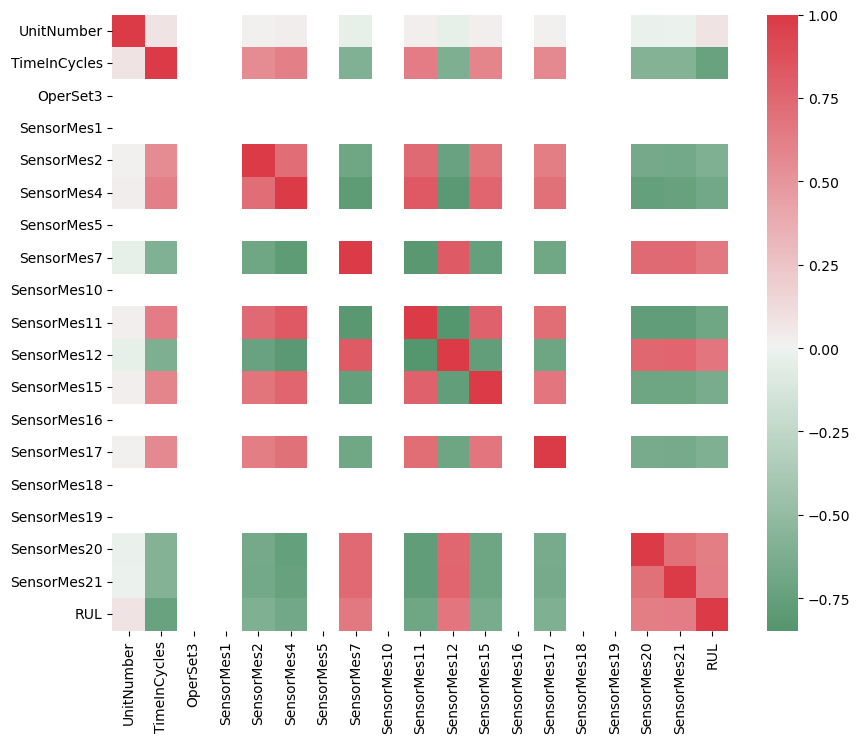

In [79]:
correl(train_fd004)

In [80]:
correlation_analyz(train_fd004, 0.03)

Colonnes avec corrélation plus faible que 0.03 pour la corrélation de Pearson:
['UnitNumber', 'OperSet1', 'OperSet2', 'OperSet3', 'SensorMes1', 'SensorMes2', 'SensorMes5', 'SensorMes6', 'SensorMes7', 'SensorMes8', 'SensorMes9', 'SensorMes10', 'SensorMes12', 'SensorMes13', 'SensorMes15', 'SensorMes18', 'SensorMes19', 'SensorMes20', 'SensorMes21']

Colonnes avec corrélation plus faible que 0.03 pour la corrélation de Spearman:
['UnitNumber', 'OperSet1', 'OperSet2', 'OperSet3', 'SensorMes1', 'SensorMes5', 'SensorMes7', 'SensorMes12', 'SensorMes15', 'SensorMes18', 'SensorMes19', 'SensorMes20', 'SensorMes21']

Colonnes avec corrélation plus faible que 0.03 pour la corrélation de Kendall:
['UnitNumber', 'OperSet1', 'OperSet2', 'OperSet3', 'SensorMes1', 'SensorMes5', 'SensorMes6', 'SensorMes7', 'SensorMes12', 'SensorMes15', 'SensorMes18', 'SensorMes19', 'SensorMes20', 'SensorMes21']


In [81]:
# Les colonnes à supprimer
operSets_to_drop = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
sensorMes_to_drop = ["SensorMes"+str(j) for j in [1, 5, 6, 7, 12, 15, 18, 19, 20, 21]]
cols_to_drop = operSets_to_drop + sensorMes_to_drop

# Suppression dans train et test
drop_cols=True
if(drop_cols == True):
  train_fd004 = train_fd004.drop(cols_to_drop, axis=1)
  test_fd004 = test_fd004.drop(cols_to_drop, axis=1)

In [82]:
train_fd004.columns, len(train_fd004.columns)

(Index(['UnitNumber', 'TimeInCycles', 'SensorMes2', 'SensorMes3', 'SensorMes4',
        'SensorMes8', 'SensorMes9', 'SensorMes10', 'SensorMes11', 'SensorMes13',
        'SensorMes14', 'SensorMes16', 'SensorMes17', 'RUL'],
       dtype='object'),
 14)

# **RANDOM SAMPLE SELECTION**

In [83]:
'''element_counts = test_fd002[test_fd002['UnitNumber']==1]
len(element_counts)'''

"element_counts = test_fd002[test_fd002['UnitNumber']==1]\nlen(element_counts)"

In [84]:
import random

def selection_aleatoire(df, sample_size, rand_state):
    unique_values = df["UnitNumber"].unique()
    selected_rows = []
    for value in unique_values:
        rows = df[df["UnitNumber"] == value]
        if len(rows) < sample_size : # si la taille de l'echantillon donnée est superieur au nombre total de ligne pour un moteur, reinitialiser la valeur
            sample_size = len(rows)
        random_sample = rows.sample(n=sample_size, random_state = rand_state)  # Sélectionne 50 lignes aléatoires
        selected_rows.append(random_sample)
    result = pd.concat(selected_rows)
    return result

# **Data normalization**

In [85]:
def normalised_df(train, test):

  from sklearn.preprocessing import MinMaxScaler

  # Instancier l'objet MinMaxScaler pour normaliser les données
  scaler = MinMaxScaler()

  # Normaliser train
  train_scaled = scaler.fit_transform(train)
  train_df = pd.DataFrame(train_scaled)

  # Normaliser test
  test_scaled = scaler.fit_transform(test)
  test_df = pd.DataFrame(test_scaled)


  train_df.columns = train.columns
  test_df.columns = test.columns
    
  return train_df, test_df

# **Data splitting**

In [86]:
def data_split(train, test):

  # data split
  X_train = train.drop('RUL', axis=1)
  Y_train = train['RUL']
  X_test = test.drop('RUL', axis=1)
  Y_test = test['RUL']
    
  return X_train, Y_train, X_test, Y_test


# calcul de S-score

In [87]:
#calcul de S-score
def compute_s_score(rul_true, rul_pred):
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

# **The XGB Regressor model**

In [88]:
import time

def my_XGB_Regressor(x, y):

    # Time tracking, Operation time (min)
    t = time.process_time()


    mse_test_list = []
    rmse_test_list = []
    mae_test_list = []
    mape_test_list = []
    #s_score_list = []
    
    
    for j in range(1, 11):
        train_selected = selection_aleatoire(x, 50, j)
        test_selected = selection_aleatoire(y, 25, j)

        normalized_train_df, normalized_test_df =  normalised_df(train_selected, test_selected)

        X_train, Y_train, X_test, Y_test = data_split(normalized_train_df, normalized_test_df)

        # Créer le modèle XGBoost Regressor
        model = XGBRegressor()

        # Définir les paramètres à tester dans la recherche par grille
        param_grid = {
            'n_estimators': [100, 500, 1000],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3], #np.logspace(-3,-1,10)
            'subsample': [0.5, 0.7, 0.9],
            'colsample_bytree': [0.5, 0.7, 0.9],
            }

        # Créer l'objet GridSearchCV
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

        # Effectuer la recherche par grille sur les données d'entraînement
        grid_search.fit(X_train, Y_train)

        # Afficher les meilleurs paramètres trouvés
        print("Meilleurs paramètres trouvés :")
        print(grid_search.best_params_)
        
        # Créer l'objet GridSearchCV
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

        # Effectuer la recherche par grille sur les données d'entraînement
        grid_search.fit(X_train, Y_train)

        print("\n***********************TOUR No ",j,"/10:************************")

        # Afficher les meilleurs paramètres trouvés
        print("Meilleurs paramètres trouvés :")
        print(grid_search.best_params_)

        '''#-------------Train---------------------
        # Prédire les valeurs en utilisant le modèle KNN Regressor pour les données Train
        y_pred_train = grid_search.predict(X_train)
        # Afficher l'erreur quadratique moyenne et le coefficient de détermination R2
        mse_train = mean_squared_error(Y_train, y_pred_train)
        rmse_train = np.sqrt(mse_train)
        print('Train:==========================================================')
        print('MSE : ',mse_train * 100,'%')
        print('RMSE : ',rmse_train * 100,'%')'''

        #-------------Test---------------------
        # Prédire les valeurs en utilisant le modèle KNN Regressor pour les données Test
        y_pred_test = grid_search.predict(X_test)
        # Afficher l'erreur quadratique moyenne et le coefficient de détermination R2
        mse_test = mean_squared_error(Y_test, y_pred_test)
        rmse_test = np.sqrt(mse_test)
        mae_test = mean_absolute_error(Y_test, y_pred_test)
        mape_test = np.mean(np.abs((Y_test - y_pred_test) / Y_test)) * 100
        s_score = compute_s_score(Y_test, y_pred_test)

        print('\n=============================Test=============================')
        print('MSE : ',mse_test * 100,'%')
        print('RMSE : ',rmse_test * 100,'%')
        print('MAE : ',mae_test * 100,'%')
        print('MAPE : ',mape_test,'%')
        #print("S-score: ", s_score)

        #score
        '''train_rmse_list.append(mse_train)'''
        mse_test_list.append(mse_test)
        rmse_test_list.append(rmse_test)
        mae_test_list.append(mae_test)
        mape_test_list.append(mape_test)
        #s_score_list.append(s_score)
        
        print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        print("time: " , (time.process_time()-t)/60,"min")
        print('')
        
        
        
    print("\n\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Total time: " , (time.process_time()-t)/60,"min")
    
    #print('All S-Score: ',s_score_list)
    #print('\n mean S-Score', np.mean(s_score_list),'\n')
    
    print('All MSE: ',mse_test_list)
    print('mean MSE', np.mean(mse_test_list), " == ",np.mean(mse_test_list)*100,"%\n")
    
    print('All RMSE: ',rmse_test_list)
    print('\n******************************************************************************************')
    print('******************************************************************************************')
    print('***************** mean RMSE', np.mean(rmse_test_list), " ==> ",np.mean(rmse_test_list)*100,"% ***************")
    print('******************************************************************************************')
    print('******************************************************************************************\n')


    print('mean MAE : ', np.mean(mae_test_list) * 100,'%')
    print('mean MAPE : ', np.mean(mape_test_list),'%')

In [89]:
my_XGB_Regressor(train_fd001, test_fd001)

Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}

***********************TOUR No  1 /10:************************
Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}

=============================Test=============================
MSE :  1.9573064469479988 %
RMSE :  13.990376860356546 %
MAE :  10.175373593367224 %
MAPE :  inf %
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
time:  191.64791666666667 min

Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.7}

***********************TOUR No  2 /10:************************
Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.7}

=============================Test=============================
MSE :  2.5370

In [90]:
my_XGB_Regressor(train_fd002, test_fd002)

Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}

***********************TOUR No  1 /10:************************
Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}

=============================Test=============================
MSE :  2.3365264584295393 %
RMSE :  15.285700698461746 %
MAE :  11.879870087802809 %
MAPE :  inf %
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
time:  631.3864583333333 min

Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.5}

***********************TOUR No  2 /10:************************
Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.5}

=============================Test=============================
MSE :  2.47175

In [91]:
my_XGB_Regressor(train_fd003, test_fd003)

Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}

***********************TOUR No  1 /10:************************
Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}

=============================Test=============================
MSE :  2.424346095563789 %
RMSE :  15.570311800229913 %
MAE :  11.867603884115496 %
MAPE :  inf %
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
time:  236.45729166666666 min

Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}

***********************TOUR No  2 /10:************************
Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}

=============================Test=============================
MSE :  3.12988

In [92]:
my_XGB_Regressor(train_fd004, test_fd004)

Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.5}

***********************TOUR No  1 /10:************************
Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.5}

=============================Test=============================
MSE :  2.7580051524560654 %
RMSE :  16.60724285501981 %
MAE :  12.351272294092281 %
MAPE :  inf %
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
time:  497.64296875 min

Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}

***********************TOUR No  2 /10:************************
Meilleurs paramètres trouvés :
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}

=============================Test=============================
MSE :  2.58225157416